<a href="https://colab.research.google.com/github/rbhardwaj2186/Project_ML/blob/main/Rakshit_Bhardwaj_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture ResNet Model**

In this module we will implement the architecture of ResNet. ResNet Model like VGG also has multiple configurations. Each configuration specifies the number of layers and the size of each layer.

This model was introduced in 2015 and is given in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

<br>

The basic idea behind the ResNet network is the `Residual Connection`.

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. There is an example of an identity residual connection given below:

<img src ="https://drive.google.com/uc?export=view&id=1qhL6RwBzujtOMM-t1oMFfK4T8IxLgsnk" width = 500 >

<br>

The different ResNet configurations are given as:

<img src ="https://drive.google.com/uc?export=view&id=19fMY19sKoiLmdSh2-vnAdRJoKn4fUeFj" width = 500 >

<br>

**We will not implement any of the above deep networrks. We will just show how the residual blocks can be implemented in PyTorch.**

# <Font color = 'pickle'>**ResNet with identity blocks**
<img src ="https://drive.google.com/uc?export=view&id=1OIjA4aLDI8q_ENAuuRQroGa0nli7CXBl" width = 500 >
<br><br>
<img src ="https://drive.google.com/uc?export=view&id=1HGXAcIifqNAkhhIbFkbvaa5CT5xxXoPw" width = 500 >

Picture taklen from : https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb

# Setup environment

In [ ]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content/drive/MyDrive/data/fmnist_data/')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
custom_function_folder = base_folder/'Colab Notebooks/Custom'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed/oct-17'
model_folder.mkdir(parents=True, exist_ok=True)
#project_folder = base_folder/'data/imagenette2'
project_folder = base_folder/'Colab Notebooks/Custom'
kaggle_api_folder = base_folder/'data/.kaggle'

In [ ]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

#from data_module_imagenette2 import ImagenetteDataModule
from data_module_cifar10 import CIFAR10DataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import check_loader, check_transforms, check_label_dist, show_confusion_matrix, compute_accuracy, plot_losses_acc

In [ ]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [ ]:
trans1 = transforms.ToTensor()

# Transform 2: Normalize the tensor images.
# The specified mean and standard deviation values are dataset-specific.
trans2 = transforms.Normalize((0.2857,), (0.3528))

# Combine the above transformations into a single composite transform.
trans = transforms.Compose([trans1, trans2])

# Model

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.main_path(x)
        residual = self.downsample(residual)
        out += residual
        out = nn.ReLU(inplace=True)(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Output: 16x32x32
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            ResidualBlock(16, 32, stride=1),                       # Output: 32x32x32
            ResidualBlock(32, 64, stride=2),                       # Output: 64x16x16
            ResidualBlock(64, 128, stride=2),                      # Output: 128x8x8
            # Adjust the number of residual blocks and channels as needed
            nn.AdaptiveAvgPool2d((1, 1))                          # Output: 128x1x1
        )

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=10)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 304842
Trainable parameters: 304842


# Function to load the model

In [ ]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(model_config['num_classes'])
    return model


# Functions for Transformations

# Function to load DataModule

In [ ]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = trans  # Assuming you have a transform function named 'trans'
    test_transform = trans  # Assuming the same transform for train and test

    dm = CIFAR10DataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm



# Function to load LightningModule

In [ ]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [ ]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [ ]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [ ]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [ ]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config1.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config1.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [ ]:
# Load components
free_memory()
seed_everything(42)
_, _, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
model_config = {'num_classes': 10}
data_module_config = {'data_module': {'batch_size': 64, 'seed': 42}}
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 304 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
304 K     Trainable params
0         Non-trainable params
304 K     Total params
1.219     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytor

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.39, Train_Metric: 0.06


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0031622776601683794
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d1e87fd3-3199-4de6-b264-e3b66622ec31.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d1e87fd3-3199-4de6-b264-e3b66622ec31.ckpt


Train_Loss: 2.21, Train_Metric: 0.19
0.0031622776601683794


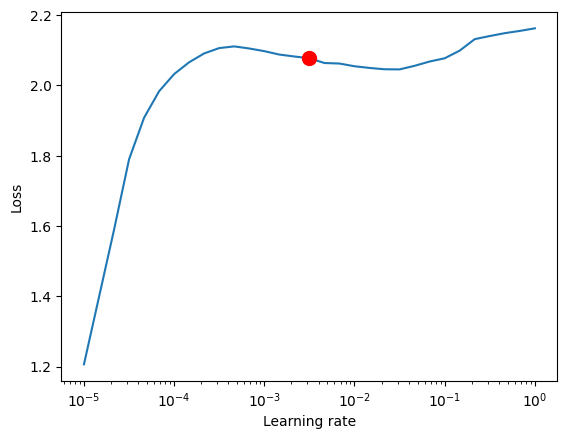

In [ ]:
free_memory()
seed_everything(42)
_, _, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
model_config = {'num_classes': 10}
data_module_config = {'data_module': {'batch_size': 64, 'seed': 42}}
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


In [ ]:
free_memory()
seed_everything(42)
_, _, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
model_config = {'num_classes': 10}
data_module_config = {'data_module': {'batch_size': 64, 'seed': 42}}

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.001
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['others']['learning_rate']=0.003
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='fminst'
cl_config['wandb']['name']='resnet'

# data_module_config['data_module']['small_subset']=True
# data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup('fit')
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 304 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
304 K     Trainable params
0         Non-trainable params
304 K     Total params
1.219     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.50, Val_Metric: 0.42 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved. New best score: 0.425


Train_Loss: 1.48, Train_Metric: 0.46


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.34, Val_Metric: 0.52 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.098 >= min_delta = 0.0. New best score: 0.523


Train_Loss: 1.21, Train_Metric: 0.57
Epoch 00002: reducing learning rate of group 0 to 1.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.32, Val_Metric: 0.52 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.000 >= min_delta = 0.0. New best score: 0.523


Train_Loss: 0.98, Train_Metric: 0.66
Epoch 00003: reducing learning rate of group 0 to 7.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.04, Val_Metric: 0.64 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.118 >= min_delta = 0.0. New best score: 0.641


Train_Loss: 0.81, Train_Metric: 0.72
Epoch 00004: reducing learning rate of group 0 to 3.7500e-04.


In [ ]:
file = f"{trainer.logger.log_dir}/metrics.csv"
print(file)

In [ ]:
plot_losses_acc(file)